# Tensor-Hyper Contraction with Qubitization-QPE - Resource Estimates

In [2]:
from openfermion.resource_estimates.utils import QI
import numpy as np
from qualtran.bloqs.chemistry.thc.prepare_test import build_random_test_integrals
from qualtran.bloqs.chemistry.thc.walk_operator import get_walk_operator_for_thc_ham
from qualtran.bloqs.phase_estimation import LPResourceState, QubitizationQPE
import pandas as pd
import matplotlib.pyplot as plt


## Utilities

In [3]:

def convert_to_num_label(num):
    if num >= 1000000000000:
        return f"{num / 1000000000000:.1f} Trillion"
    elif num >= 1000000000:
        return f"{num / 1000000000:.1f} Billion"
    elif num >= 1000000:
        return f"{num / 1000000:.1f} Million"
    elif num >= 1000:
        return f"{num / 1000:.1f} K"
    

def convert_to_int(s):
    # Check if the last character is 'k'
    if s[-1].lower() == 'k':
        number = float(s[:-1])
        return int(number * 1000)
    elif s[-1].lower() == 'm':
       number = float(s[:-1])
       return int(number * 1000000)
    elif s[-1].lower() == 'g':
        number = float (s[:-1])
        return int(number * 1000000000)
    elif s[-1].lower() == 't':
        number = float (s[:-1])
        return int(number * 1000000000000)
    else:
        return int(s)
    
def convert_nanoseconds(nanoseconds):
    time_units = [
        ("centuries", 3153600000),
        ("decades", 315360000),
        ("years", 31536000),
        ("days", 86400),
        ("hours", 3600),
        ("mins", 60),
        ("secs", 1),
        ("millisecs", 1e-3),
        ("microsecs", 1e-6),
        ("nanosecs", 1e-9)
    ]
    seconds = nanoseconds * 1e-9  
    for unit, value in time_units:
        if seconds >= value:
            converted_value = seconds / value
            return f"{converted_value:.0f} {unit}"
    
    return f"{nanoseconds} nanosecs"

## Tensor-Hyper Contraction with Qubitzation-QPE code

In [9]:
num_spinorb = 152
num_bits_state_prep = 10
num_bits_rot = 20
thc_dim = 450
num_spat = num_spinorb // 2
qroam_blocking_factor = np.power(2, QI(thc_dim + num_spat)[0])
t_l, eta, zeta = build_random_test_integrals(thc_dim, num_spinorb // 2, seed=7)
walk = get_walk_operator_for_thc_ham(
    t_l,
    eta,
    zeta,
    num_bits_state_prep=num_bits_state_prep,
    num_bits_theta=num_bits_rot,
    kr1=qroam_blocking_factor,
    kr2=qroam_blocking_factor,
)

algo_eps = 0.0016
qpe_eps = algo_eps / (walk.block_encoding.alpha * 2**0.5)
qubitization_qpe_chem_thc = QubitizationQPE(
    walk, LPResourceState.from_standard_deviation_eps(qpe_eps)
)
counts = qubitization_qpe_chem_thc.t_complexity()

## Resource Estimates

In [10]:

def get_bloq_logical_counts(bloq):
    from qsharp.estimator import LogicalCounts
    from qualtran._infra.gate_with_registers import get_named_qubits

    num_qubits = bloq.signature.n_qubits()
    complexity = bloq.t_complexity()
    
    return LogicalCounts({
        "numQubits": num_qubits,
        "tCount": complexity.t,
        "rotationCount": complexity.rotations,
        "rotationDepth": complexity.rotations
    })

estimates = get_bloq_logical_counts(qubitization_qpe_chem_thc).estimate([
    {"errorBudget": 0.01,
    "qubitParams": {"name": "qubit_maj_ns_e6"},
    "qecScheme": {"name": "floquet_code"}}
    # {"qubitParams": {"name": "qubit_gate_ns_e4"}},
    # {"qubitParams": {"name": "qubit_maj_ns_e4"}, "surfaceCode": {"name": "floquet_code"}},
])


total_gates = counts.t + counts.rotations

data = {
    "Orbitals": num_spinorb // 2,
    "Logical Qubits": [estimates['physicalCountsFormatted']['logicalCountsNumQubits']],
    "T-Gates":  [convert_to_num_label(counts.t)],
    "Logical Gates": [convert_to_num_label(total_gates)],
    "Runtime":[estimates['physicalCountsFormatted']['runtime']]
}

print(data)

{'Orbitals': 76, 'Logical Qubits': ['226'], 'T-Gates': ['178160.5 Trillion'], 'Logical Gates': ['178164.9 Trillion'], 'Runtime': ['525 years']}


## Results

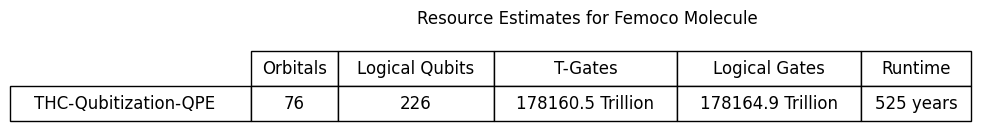

In [11]:
algorithms = ["THC-Qubitization-QPE"]
df = pd.DataFrame(data, index=algorithms)

fig, ax = plt.subplots(figsize=(8, 1))
ax.axis('off')

table = ax.table(
    cellText=df.values,
    rowLabels=df.index,
    colLabels=df.columns,
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1], 
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(df.columns) + 1)))
for (row, col), cell in table.get_celld().items():
    cell.set_height(0.3) 

plt.subplots_adjust(left=0.05, right=0.95, top=0.8, bottom=0.1)

plt.title("Resource Estimates for Femoco Molecule", pad=20)
plt.show()


## Above Results are wrong. Tensor-Hyper Contraction should give better results than Double Factorization. Needs Further Implementation.